<a href="https://colab.research.google.com/github/coldfir3/KAGGLE-SETI/blob/main/SETI%20V5.0%20(Deep%20One%20class%20classification%20with%20Mean%20Shifted%20Contrastive%20Loss).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/talreiss/Mean-Shifted-Anomaly-Detection

In [1]:
import sys
import os
is_colab = 'google.colab' in sys.modules
!nvidia-smi

Mon Aug 16 14:29:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:0A:00.0  On |                  N/A |
| 46%   56C    P0   118W / 260W |    556MiB / 10997MiB |     32%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
if is_colab:
    ! pip install -Uqqq wandb
    ! pip install -Uqqq fastai
    ! pip install -Uqqq timm
    ! pip install -Uqqq faiss
    ! pip install -Uqqq faiss-gpu

In [3]:
from fastai.vision.all import *
import wandb
from fastai.callback.wandb import *
import timm

In [4]:
wandb.Api()
if is_colab:

    from google.colab import drive
    from os.path import exists

    if not exists('/content/drive'):
        drive.mount('/content/drive')
    %run '/content/drive/MyDrive/Kaggle/My Kaggle [colab].ipynb'

    if not exists('/content/train/'):
        setup_kaggle()
        get_kaggle_data('d', 'coldfir3/seti-spatial-dataset-v3')
        ! kaggle competitions download -c seti-breakthrough-listen -f train_labels.csv

In [5]:
from sklearn.model_selection import StratifiedKFold
if is_colab: 
    base_path = '/content/train/'
    train_df = pd.read_csv('/content/train_labels.csv.zip')
else:
    base_path = '/media/passos/Data/DSET/seti-spatial-dataset-v3/train/'
    train_df = pd.read_csv('/media/passos/Data/DSET/seti-spatial-dataset-v3/train_labels.csv.zip')

# train_df = train_df.sample(n=10_000).reset_index(drop=True)
train_df['fold'] = -1
train_df['path'] = train_df['id'].apply(lambda x: base_path + x + '.png')
train_df['label'] = train_df['target'].apply(lambda x: 'alien' if x == 1 else 'no-alien')
skf = StratifiedKFold(n_splits = 6, random_state = 42, shuffle = True)
for fold, (train_index, test_index) in enumerate(skf.split(train_df['id'], train_df['target'])):
    train_df.loc[test_index, 'fold'] = fold
train_df.loc[train_df['target'] == 1, 'fold'] = -1
train_df


,id,target,fold,path,label
0,0000799a2b2c42d,0,3,/media/passos/Data/DSET/seti-spatial-dataset-v3/train/0000799a2b2c42d.png,no-alien
1,00042890562ff68,0,3,/media/passos/Data/DSET/seti-spatial-dataset-v3/train/00042890562ff68.png,no-alien
2,0005364cdcb8e5b,0,4,/media/passos/Data/DSET/seti-spatial-dataset-v3/train/0005364cdcb8e5b.png,no-alien
3,0007a5a46901c56,0,3,/media/passos/Data/DSET/seti-spatial-dataset-v3/train/0007a5a46901c56.png,no-alien
4,0009283e145448e,0,3,/media/passos/Data/DSET/seti-spatial-dataset-v3/train/0009283e145448e.png,no-alien
...,...,...,...,...,...
59995,fff8217fe05aba3,0,4,/media/passos/Data/DSET/seti-spatial-dataset-v3/train/fff8217fe05aba3.png,no-alien
59996,fffa939e610ed70,0,4,/media/passos/Data/DSET/seti-spatial-dataset-v3/train/fffa939e610ed70.png,no-alien
59997,fffbb1c9c3d6c31,1,-1,/media/passos/Data/DSET/seti-spatial-dataset-v3/train/fffbb1c9c3d6c31.png,alien
59998,fffc9a763d23647,0,0,/media/passos/Data/DSET/seti-spatial-dataset-v3/train/fffc9a763d23647.png,no-alien


In [6]:
import albumentations as A
class AlbumentationsTransform(Transform):
    split_idx = 0
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
tfms = A.Compose([
        A.HorizontalFlip(p=.5),
        A.VerticalFlip(p=.5),
        A.ShiftScaleRotate(rotate_limit=0, p=.25),
        A.MotionBlur(p=.2),
        A.IAASharpen(p=.25)
])

/home/passos/anaconda3/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)


In [7]:
def get_dls(df, **config):
    is_colab = 'google.colab' in sys.modules
    workers = 2 if is_colab else 10
    splitter = IndexSplitter(df[df.fold == config['fold']].index)
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), ImageBlock(cls=PILImageBW), CategoryBlock(vocab = [0,1])),
        splitter = splitter,
        getters=[ColReader('path'), ColReader('path'), ColReader('target')],
        item_tfms=AlbumentationsTransform(tfms),
        batch_tfms=[Flip(), Normalize(mean = tensor(0.5), std = tensor(0.177))],
        n_inp = 2
        ).dataloaders(df, bs = config['bs'], num_workers = workers)
        
dls = get_dls(train_df.loc[train_df['fold'] != -1].reset_index(drop=True), **{'bs':8, 'fold':0})
# dls.show_batch()

In [8]:
# for xb0, xb1, yb in tqdm(iter(dls[0])):
#     if sum(yb) > 0:
#         print('ERROR')

In [9]:
xb0, xb1, yb = dls.one_batch()

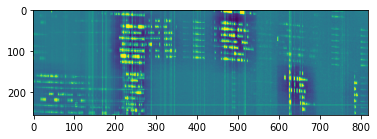

In [10]:
plt.imshow((xb0[0].cpu()*0.177 + 0.5)[0]);

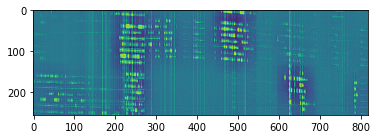

In [11]:
plt.imshow((xb1[0].cpu()*0.177 + 0.5)[0]);

In [12]:
def contrastive_loss(out_1, out_2):
    out_1 = F.normalize(out_1, dim=-1)
    out_2 = F.normalize(out_2, dim=-1)
    bs = out_1.size(0)
    temp = 0.25
    # [2*B, D]
    out = torch.cat([out_1, out_2], dim=0)
    # [2*B, 2*B]
    sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / temp)
    mask = (torch.ones_like(sim_matrix) - torch.eye(2 * bs, device=sim_matrix.device)).bool()
    # [2B, 2B-1]
    sim_matrix = sim_matrix.masked_select(mask).view(2 * bs, -1)

    # compute loss
    pos_sim = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temp)
    # [2*B]
    pos_sim = torch.cat([pos_sim, pos_sim], dim=0)
    loss = (- torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean()

    center_loss = ((out_1 ** 2).sum(dim=1).mean() + (out_2 ** 2).sum(dim=1).mean())

    return loss + center_loss

In [13]:
# https://arxiv.org/pdf/2103.09950.pdf
# https://github.com/yundaehyuck/Learning-to-resize-images-for-computer-vision-tasks/blob/main/resizing_network.ipynb

class ResBlock(nn.Module):
    def __init__(self,num_channels=16):
        super(ResBlock,self).__init__()
        
        self.conv1 = nn.Conv2d(num_channels,num_channels,kernel_size=3,stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.2,inplace=True)
        
        self.conv2 = nn.Conv2d(num_channels,num_channels,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self,x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        
        out = self.leakyrelu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        
        return out

def make_block(r,n):
    residual = []
    
    for i in range(r):
        block = ResBlock(num_channels=n)
        residual.append(block)
    
    return nn.Sequential(*residual)

class ResizingNetwork(nn.Module):
    def __init__(self, img_size, in_chans = 3, r=1, n=16):
        super(ResizingNetwork, self).__init__()

        self.img_size = img_size
        
        self.conv1 = nn.Conv2d(in_channels=in_chans,out_channels=n,kernel_size=7,stride=1,padding=3)
        self.leakyrelu1 = nn.LeakyReLU(negative_slope=0.2,inplace=True)
        
        self.conv2 = nn.Conv2d(n,n,kernel_size=1,stride=1)
        self.leakyrelu2 = nn.LeakyReLU(negative_slope=0.2,inplace=True)
        self.bn1 = nn.BatchNorm2d(n)
                
        self.resblock = make_block(r,n)        
        
        self.conv3 = nn.Conv2d(n,n,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(n)
        
        self.conv4 = nn.Conv2d(n,out_channels=in_chans,kernel_size=7,stride=1,padding=3)
        
    def forward(self, x):
        
        residual = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
        
        out = self.conv1(x)
        out = self.leakyrelu1(out)
        
        out = self.conv2(out)
        out = self.leakyrelu2(out)
        out = self.bn1(out)
        
        out_residual = F.interpolate(out, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
        
        out = self.resblock(out_residual)
        
        out = self.conv3(out)
        out = self.bn2(out)
        out += out_residual
        
        out = self.conv4(out)
        out += residual
        
        return out

def create_timm_model(**cfg):
    model_name = cfg.pop('arch')
    if 'img_size' in cfg.keys():
        img_size = cfg.pop('img_size')
        res = ResizingNetwork(img_size, cfg['in_chans'])
    else:
        img_size = 224
        res = Identity()
    body = timm.create_model(model_name, True, **cfg)
    model = nn.Sequential(res, body)

    ## head
    # nf = body(torch.randn((2,cfg['in_chans'],img_size,img_size))).shape[-1]
    # head = nn.Linear(nf, cfg['num_classes'])

    # model = nn.Sequential(body, head)

    return model

# model = create_timm_model(**{
#     'arch':'swin_large_patch4_window7_224',
#     'img_size':224,
#     'in_chans' : 1, 
#     'num_classes' : 1,
# })
# m

In [51]:
class CLCallback(Callback):
    def before_batch(self):
        self.learn.yb = tuple([self.xb[1]])
        self.learn.xb = tuple([self.xb[0]])
    def after_pred(self):
        self.learn.yb = tuple([self.learn.model(self.learn.yb[0])])
        
class SaveAndLogBestModel(SaveModelCallback):

    def __init__(self, mon='valid_loss', **kwargs):
        super().__init__(monitor = mon, fname = mon, **kwargs)

    def _save(self, name): 
        self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)
        self.model_path = Path(*list(self.last_saved_path.parts[:-1])) / (self.fname + '.pth')
        self.metadata = {n:s for n,s in zip(self.recorder.metric_names, self.recorder.log) if n not in ['time']}

    def after_fit(self, **kwargs):
        metadata = self.metadata
        for k,v in metadata.items(): metadata[k] = str(v)
        name = f'run_{wandb.run.id}_model'
        artifact_model = wandb.Artifact(name=name, type='model', metadata=metadata, description='trained model')
        with artifact_model.new_file(name, mode='wb') as fa:
            fa.write(self.model_path.read_bytes())
        wandb.run.log_artifact(artifact_model, aliases = [f'best {self.fname}', f'epoch {metadata["epoch"]}'])

In [ ]:
CFG = {
    'WandB' : {
        'project' : 'Seti V1',
        'tags': ['transformer', 'Constrative', 'RESIZE'],
        'notes':
        """
        """,
    },
    'Dataloader' : {
        'bs' : 16,
        'fold' : 0, 
    },
    'Model' : {
        'arch':'swin_tiny_patch4_window7_224',
        'img_size':224,
        'in_chans' : 1, 
        'num_classes' : 0,
    }
}
wandb_config = CFG.pop('WandB')
dls = get_dls(train_df, **CFG['Dataloader'])
model = create_timm_model(**CFG['Model'])
learn = Learner(dls, model, loss_func=contrastive_loss, cbs = CLCallback())
# learn.lr_find()
with wandb.init(config = CFG, **wandb_config) as run:
    learn.add_cb(WandbCallback(log=None, log_preds=False, log_model=False))
    learn.add_cb(SaveAndLogBestModel())
    learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,time
0,2.691209,2.557670,18:18
1,2.612126,2.528512,18:32
2,2.570911,2.518558,18:09
3,2.553335,2.508040,18:06
4,2.534132,2.501584,17:58
5,2.523957,2.495385,18:23
6,2.517115,2.490994,18:56


Better model found at epoch 0 with valid_loss value: 2.5576701164245605.
Better model found at epoch 1 with valid_loss value: 2.5285115242004395.
Better model found at epoch 2 with valid_loss value: 2.5185580253601074.
Better model found at epoch 3 with valid_loss value: 2.508040428161621.
Better model found at epoch 4 with valid_loss value: 2.5015838146209717.
Better model found at epoch 5 with valid_loss value: 2.4953854084014893.
Better model found at epoch 6 with valid_loss value: 2.4909939765930176.


In [ ]:
import faiss
def knn_score(train_set, test_set, n_neighbours=2):
    """
    Calculates the KNN distance
    """
    index = faiss.IndexFlatL2(train_set.shape[1])
    index.add(train_set)
    D, _ = index.search(test_set, n_neighbours)
    return np.sum(D, axis=1)
    
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
def get_score(model, train_loader, test_loader):
    train_feature_space = []
    with torch.no_grad():
        for (imgs, _, _) in tqdm(train_loader, desc='Train set feature extracting'):
            features = model(imgs)
            train_feature_space.append(features)
        train_feature_space = torch.cat(train_feature_space, dim=0).contiguous().cpu().numpy()
    test_feature_space = []
    test_labels = []
    with torch.no_grad():
        for (imgs, _, labels) in tqdm(test_loader, desc='Test set feature extracting'):
            features = model(imgs)
            test_feature_space.append(features)
            test_labels.append(labels)
        test_feature_space = torch.cat(test_feature_space, dim=0).contiguous().cpu().numpy()
        test_labels = torch.cat(test_labels, dim=0).cpu().numpy()

    distances = knn_score(train_feature_space, test_feature_space)

    auc = roc_auc_score(1-test_labels, distances)

    return auc, distances

In [ ]:
train_loader = dls.test_dl(train_df.loc[train_df.fold != 0].reset_index(drop=True), with_labels=True)
test_loader = dls.test_dl(train_df.loc[(train_df.fold == 0).values + (train_df.fold == -1).values].reset_index(drop=True), with_labels=True)
auc, d = get_score(model, train_loader, test_loader)

In [ ]:
auc